# Unsupervised image segmentation by OCCO morphological filtering

1. **K-means Segmentation** - Basic clustering-based segmentation
2. **OCCO without Reconstruction** - Opening-Closing-Closing-Opening sequence 
3. **OCCO with Reconstruction** - OCCO with morphological reconstruction for better results

In [1]:
# Import required libraries
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.ndimage import label
from matplotlib.colors import ListedColormap
from skimage.morphology import binary_closing, binary_opening, reconstruction
from skimage.measure import regionprops

In [2]:
# Load image data
msi_path = '../data/residential.tif'   

# Define custom colormap for visualization
custom_cmap = ListedColormap(['#9B59B6', '#DCDCDC', '#ADD8E6', '#FF6347'])

se = np.ones((3, 3))  # Structuring element

# Read image using rasterio
with rasterio.open(msi_path) as src:
    image = src.read() 
    profile = src.profile

# Prepare data for clustering
bands, height, width = image.shape
reshaped_image = image.reshape(bands, -1).T 

/opt/anaconda3/envs/DataCentric/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [3]:
# Perform K-means clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(reshaped_image)

# Reshape labels back to image dimensions
segmented_image = labels.reshape(height, width)

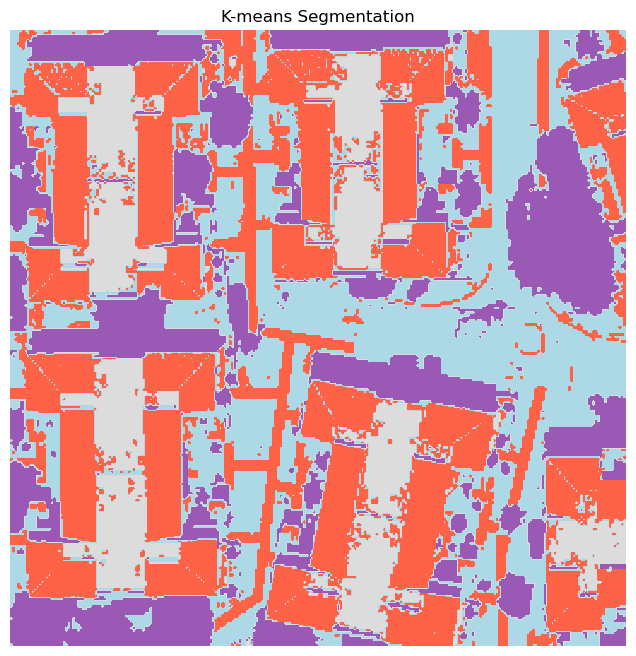

In [4]:
# Display K-means segmentation
plt.figure(figsize=(10, 8))
plt.imshow(segmented_image, cmap=custom_cmap)
plt.title("K-means Segmentation")
plt.axis("off")
plt.show()

Found 60 regions in cluster 0
Found 14 regions in cluster 1
Found 77 regions in cluster 2
Found 59 regions in cluster 3


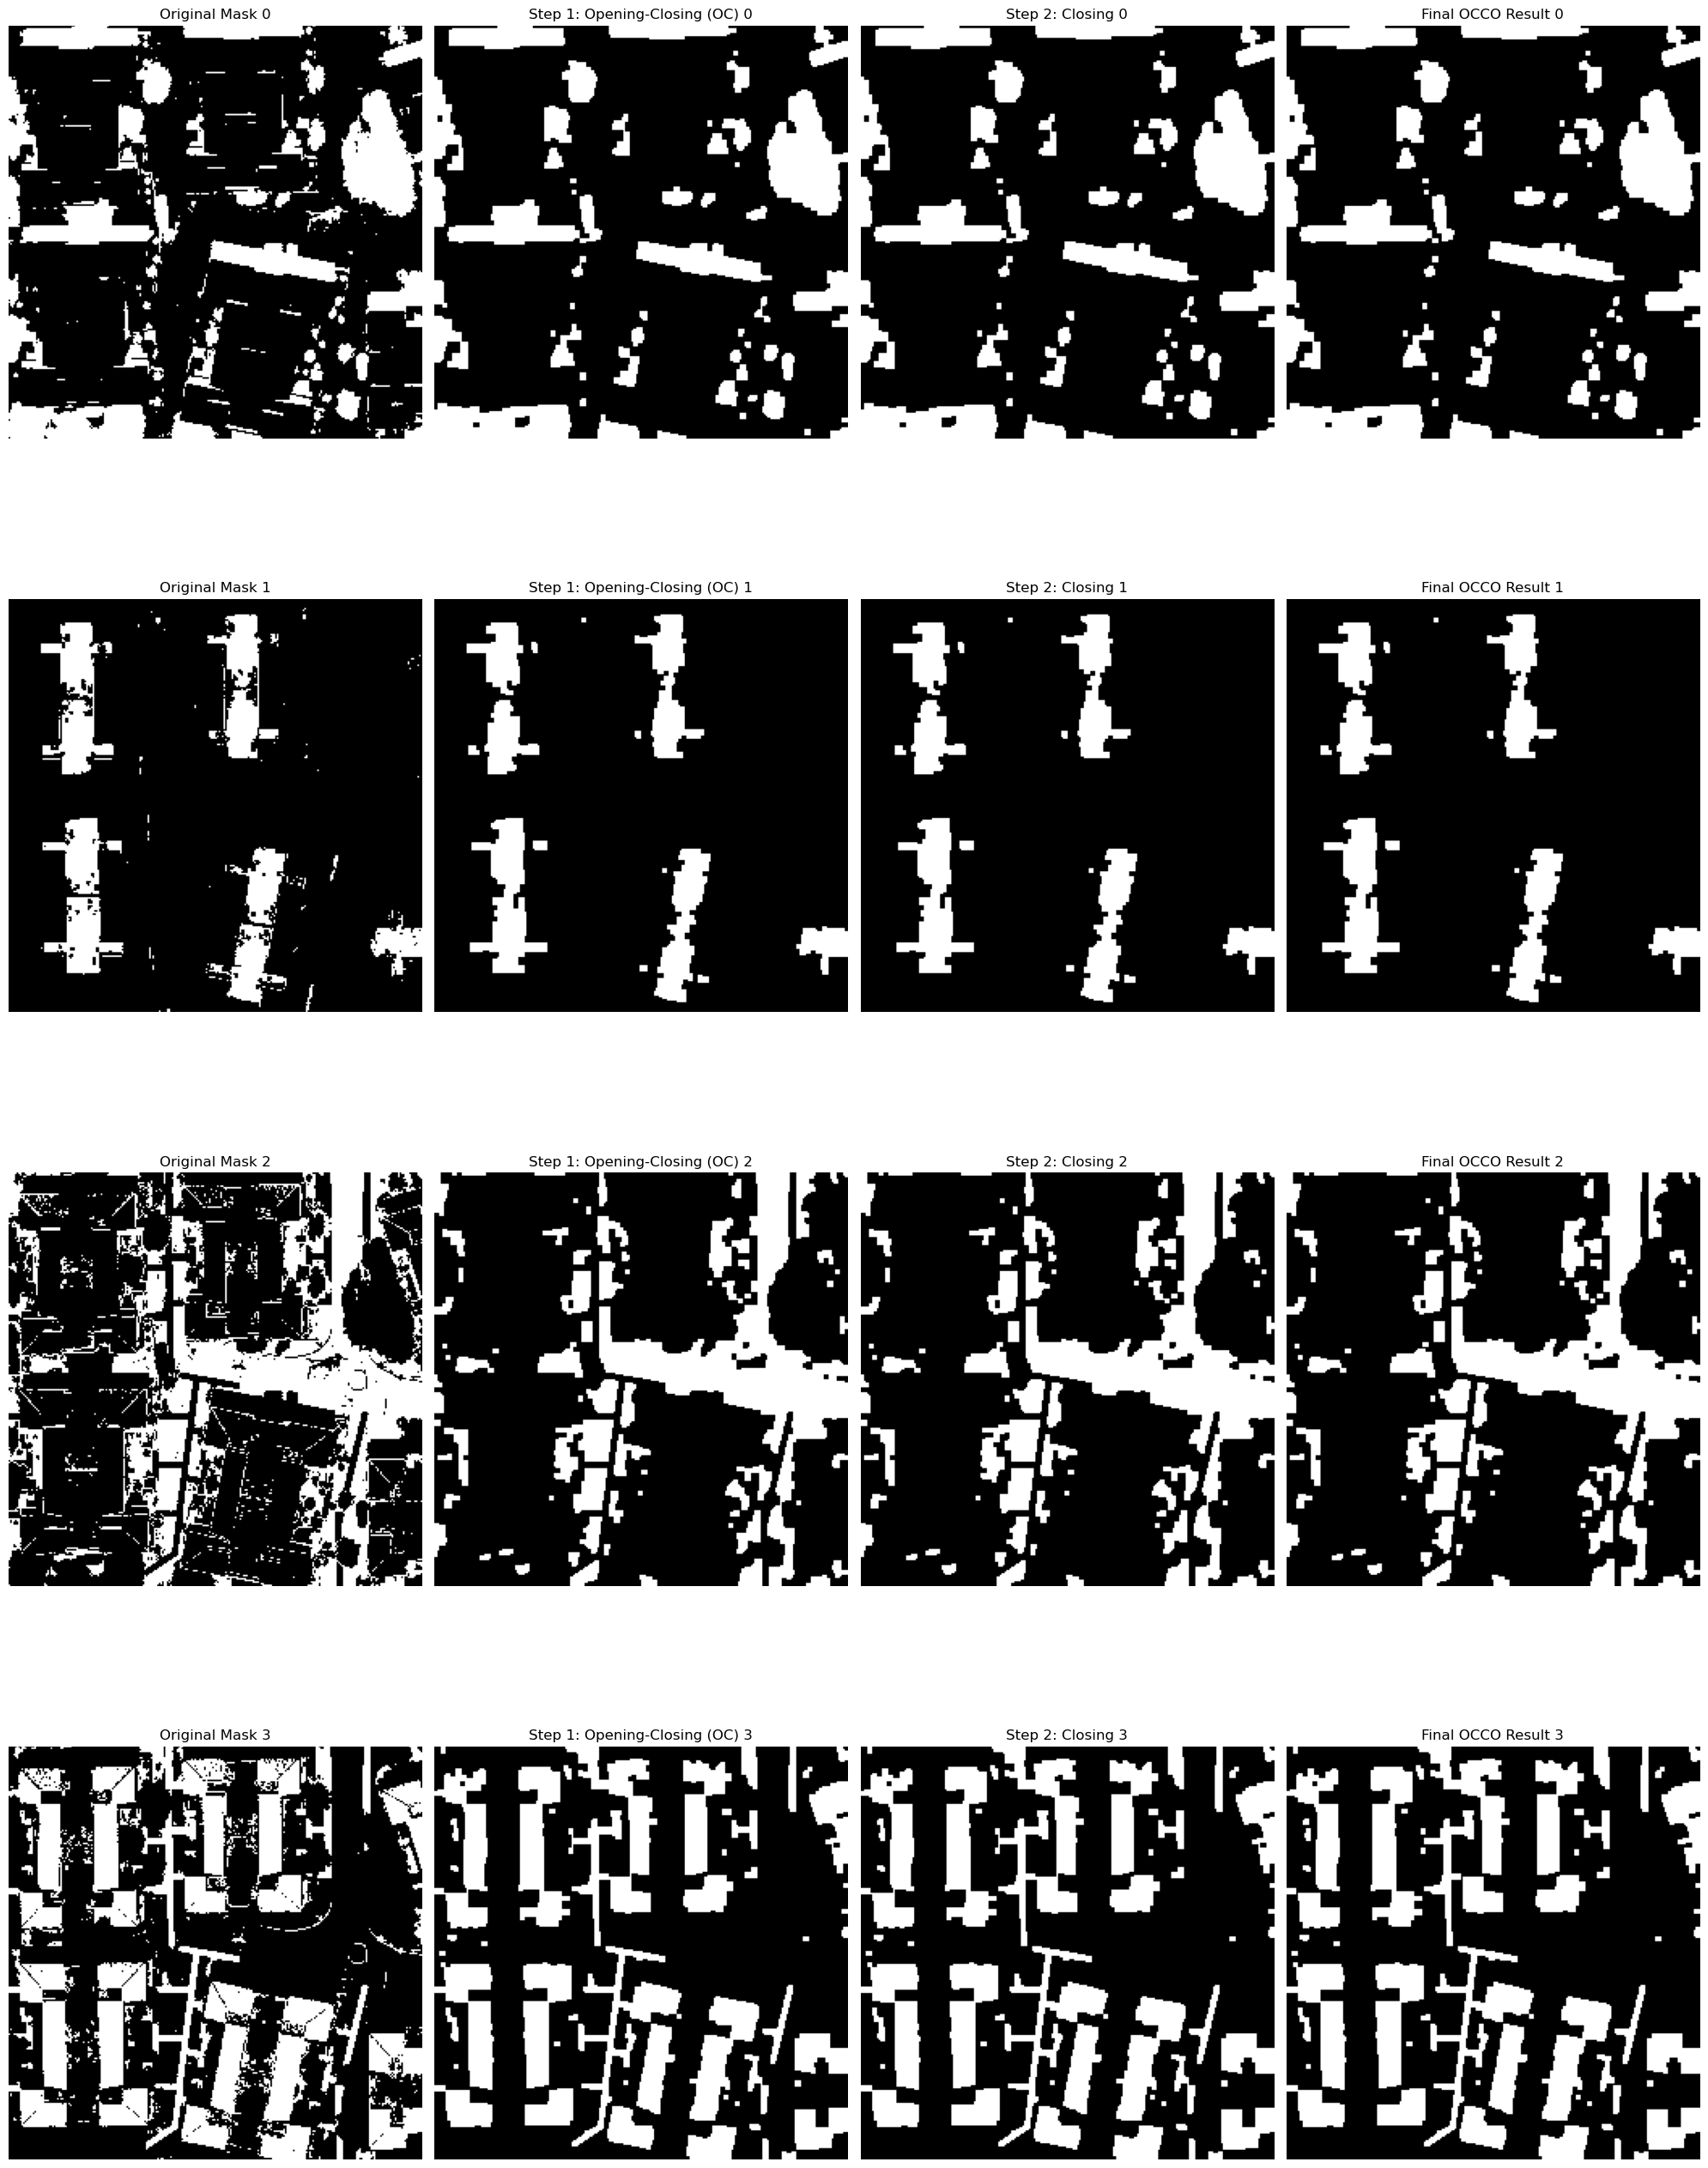

In [5]:
# OCCO (Opening-Closing-Closing-Opening) without reconstruction
fig, axes = plt.subplots(k, 4, figsize=(20, 7 * k))

final_occo_mask = np.zeros_like(segmented_image)

for i in range(k):
    # Create binary mask for current cluster
    mask = (segmented_image == i)

    # Step 1: Opening-Closing (OC)
    opened_mask = binary_opening(mask, footprint=se)
    oc_mask = binary_closing(opened_mask, footprint=se)

    # Step 2: Closing-Opening (CO) on the OC mask
    closed_mask = binary_closing(oc_mask, footprint=se)
    occo_mask = binary_opening(closed_mask, footprint=se)  # Final OCCO mask

    # Label connected regions in the OCCO mask
    labeled_regions, num_regions = label(occo_mask)
    print(f"Found {num_regions} regions in cluster {i}")

    # Resolve conflicts locally for overlapping regions
    for region in regionprops(labeled_regions):
        coords = region.coords
        existing_labels = final_occo_mask[coords[:, 0], coords[:, 1]]
        valid_labels = existing_labels[existing_labels > 0]
        
        if len(valid_labels) > 0:
            # Count label occurrences and select most frequent
            unique_labels, counts = np.unique(valid_labels, return_counts=True)
            most_frequent_label = unique_labels[np.argmax(counts)]
            final_occo_mask[coords[:, 0], coords[:, 1]] = most_frequent_label
        else:
            # No conflict: assign current cluster label
            final_occo_mask[coords[:, 0], coords[:, 1]] = i

    # Plot intermediate results for current cluster
    axes[i, 0].imshow(mask, cmap="gray")
    axes[i, 0].set_title(f"Original Mask {i}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(oc_mask, cmap="gray")
    axes[i, 1].set_title(f"Step 1: Opening-Closing (OC) {i}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(closed_mask, cmap="gray")
    axes[i, 2].set_title(f"Step 2: Closing {i}")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(occo_mask, cmap="gray")
    axes[i, 3].set_title(f"Final OCCO Result {i}")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()


Found 85 regions in cluster 0
Found 35 regions in cluster 1
Found 223 regions in cluster 2
Found 149 regions in cluster 3


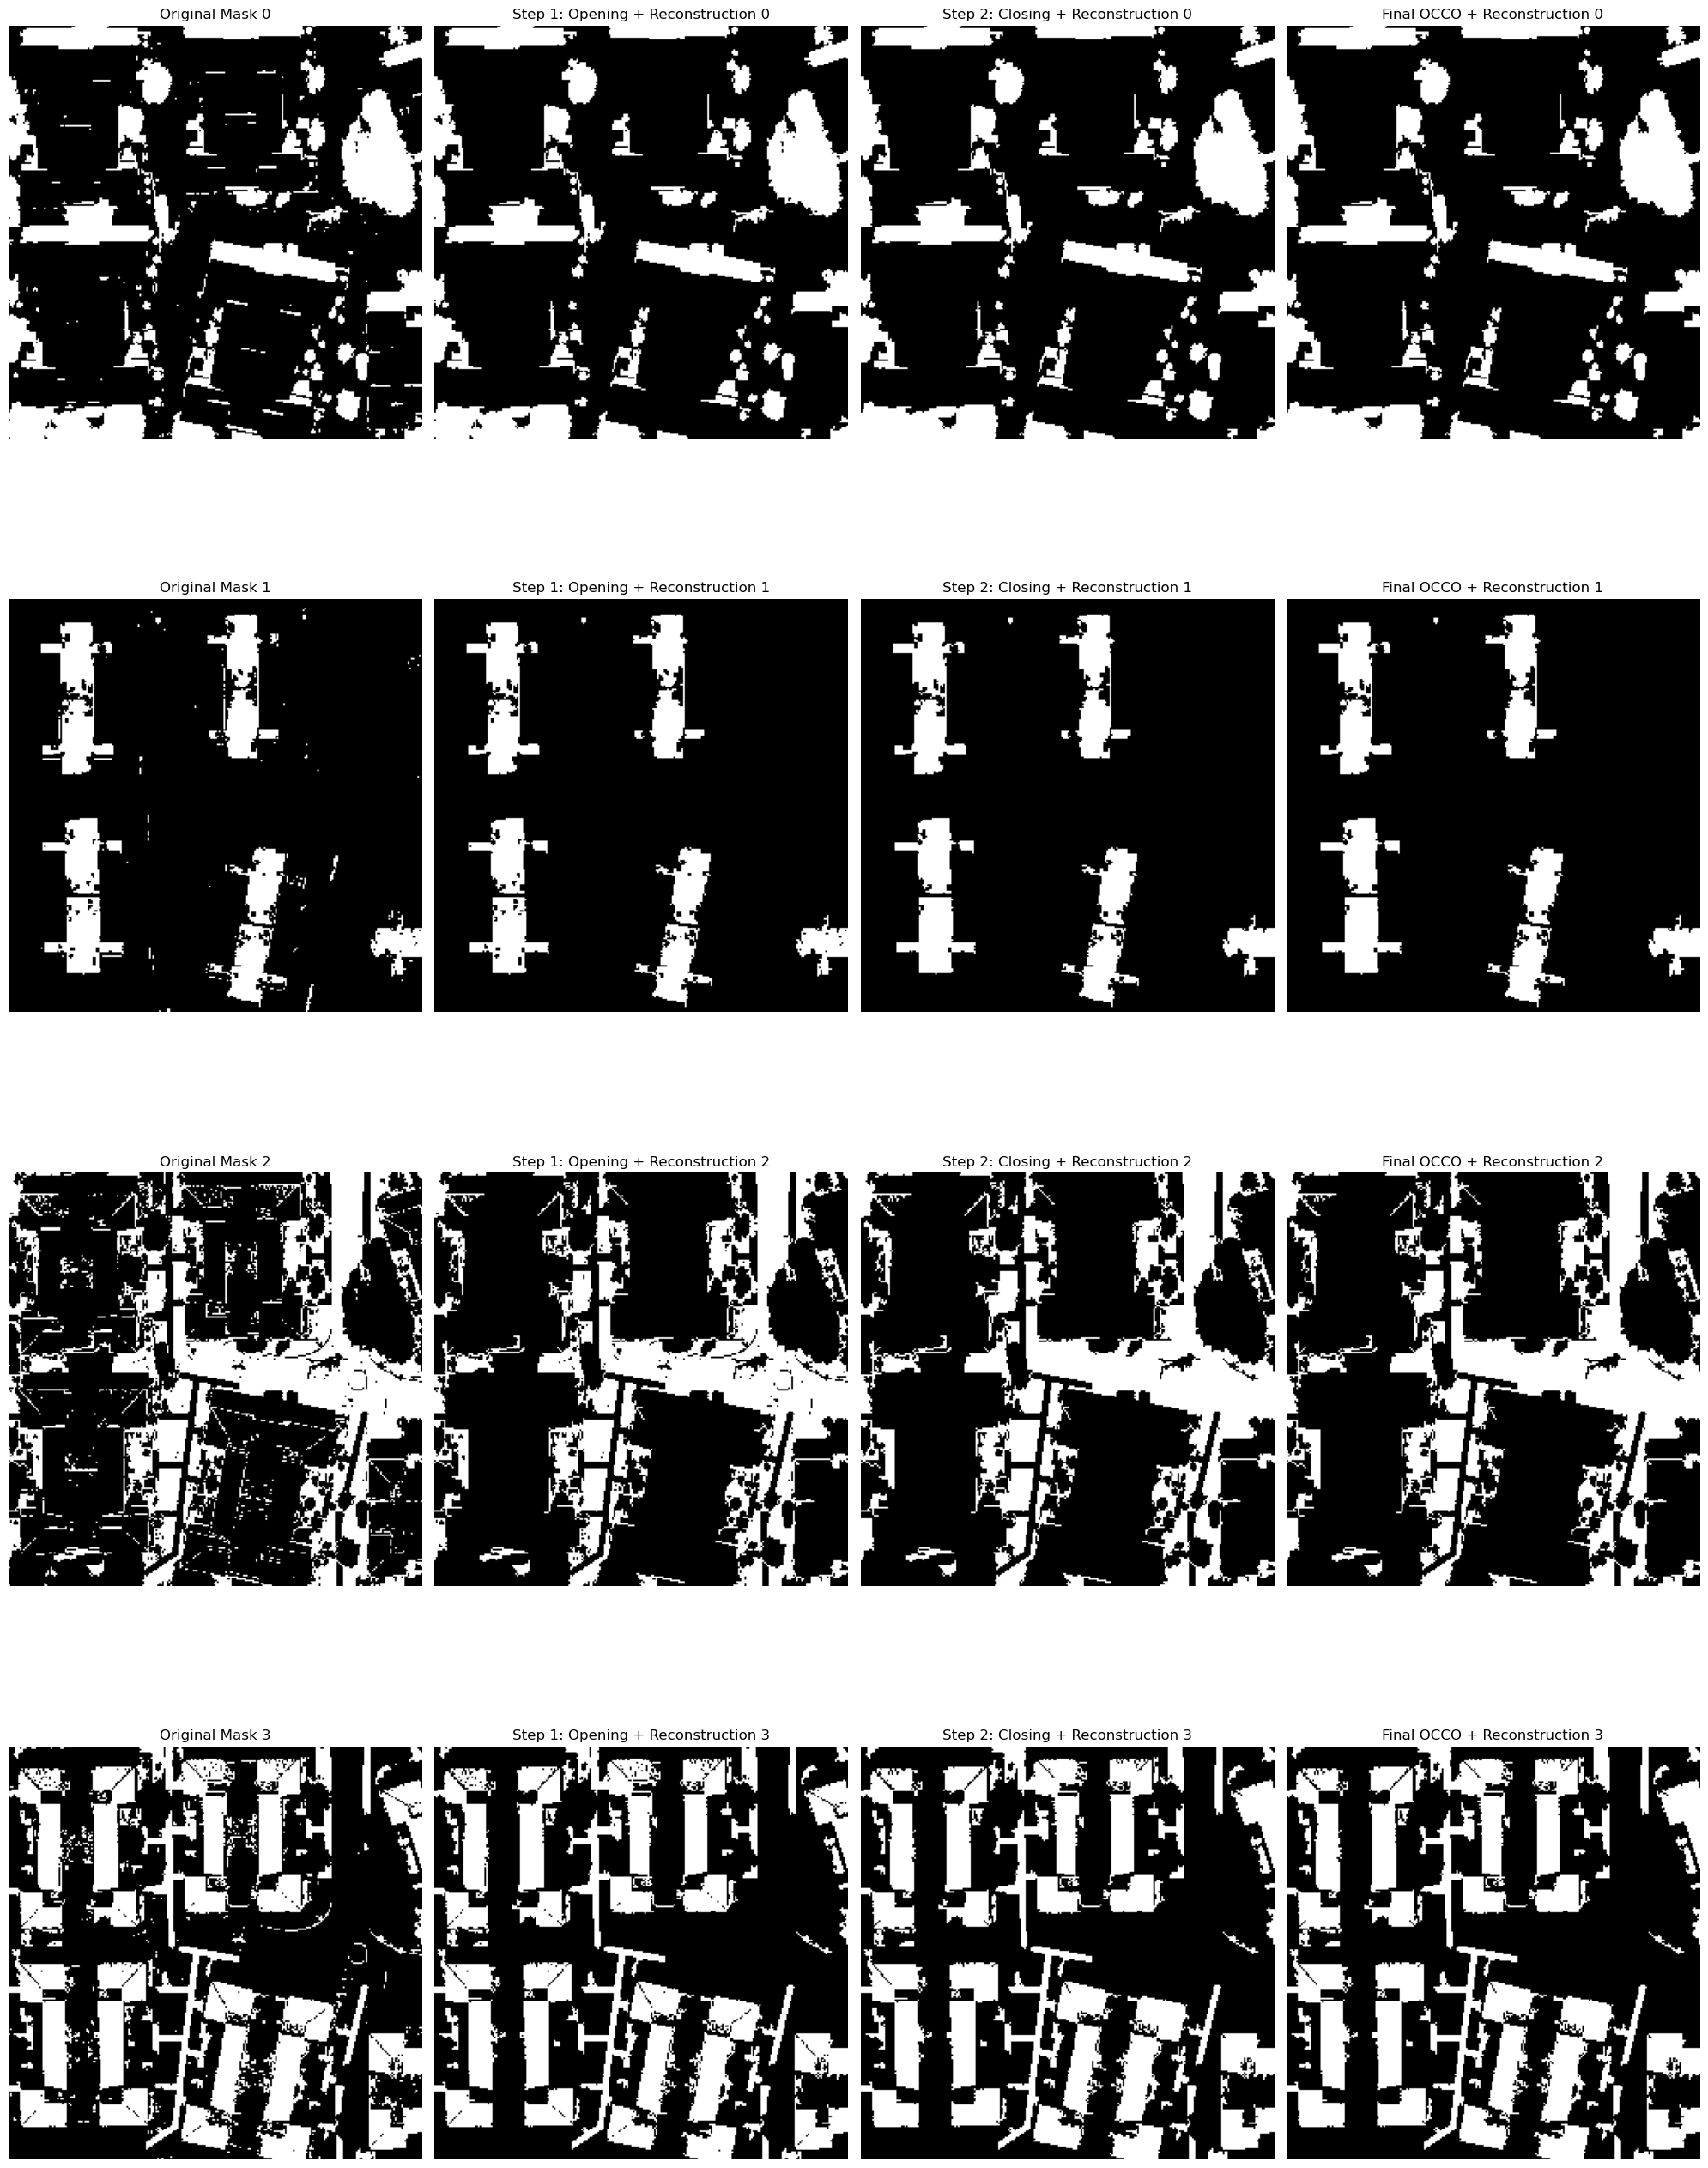

In [6]:
# OCCO (Opening-Closing-Closing-Opening) with morphological reconstruction
fig, axes = plt.subplots(k, 4, figsize=(20, 7 * k))

final_occo_recons_mask = np.zeros_like(segmented_image)

for i in range(k):
    # Create binary mask for current cluster
    mask = (segmented_image == i)

    # Step 1: Opening with reconstruction
    opened_mask = binary_opening(mask, footprint=se)
    opened_mask = reconstruction(opened_mask, mask, method='dilation')

    # Step 2: Closing with reconstruction
    oc_mask = binary_closing(opened_mask, footprint=se)
    oc_mask = reconstruction(oc_mask, opened_mask, method='erosion')

    # Step 3: Second closing with reconstruction
    closed_mask = binary_closing(oc_mask, footprint=se)
    closed_mask = reconstruction(closed_mask, oc_mask, method='erosion')

    # Step 4: Final opening with reconstruction
    occo_mask = binary_opening(closed_mask, footprint=se)
    occo_mask = reconstruction(occo_mask, closed_mask, method='dilation')

    # Label connected regions in the OCCO mask
    labeled_regions, num_regions = label(occo_mask)
    print(f"Found {num_regions} regions in cluster {i}")

    # Resolve conflicts locally for overlapping regions
    for region in regionprops(labeled_regions):
        coords = region.coords
        existing_labels = final_occo_recons_mask[coords[:, 0], coords[:, 1]]
        valid_labels = existing_labels[existing_labels > 0]
        
        if len(valid_labels) > 0:
            # Count label occurrences and select most frequent
            unique_labels, counts = np.unique(valid_labels, return_counts=True)
            most_frequent_label = unique_labels[np.argmax(counts)]
            final_occo_recons_mask[coords[:, 0], coords[:, 1]] = most_frequent_label
        else:
            # No conflict: assign current cluster label
            final_occo_recons_mask[coords[:, 0], coords[:, 1]] = i

    # Plot intermediate results for current cluster
    axes[i, 0].imshow(mask, cmap="gray")
    axes[i, 0].set_title(f"Original Mask {i}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(opened_mask, cmap="gray")
    axes[i, 1].set_title(f"Step 1: Opening + Reconstruction {i}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(closed_mask, cmap="gray")
    axes[i, 2].set_title(f"Step 2: Closing + Reconstruction {i}")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(occo_mask, cmap="gray")
    axes[i, 3].set_title(f"Final OCCO + Reconstruction {i}")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()


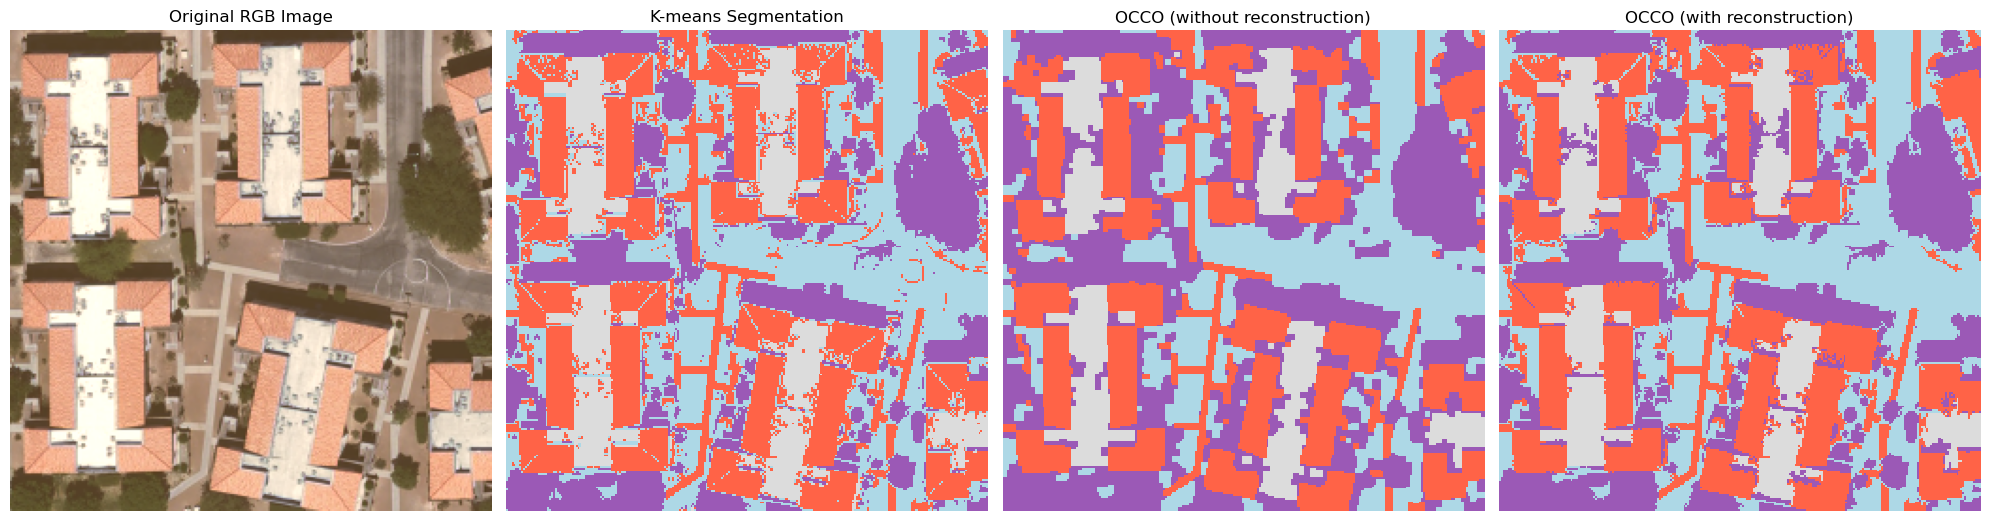

In [7]:
# Final comparison visualization

if image.shape[0] >= 3:
    rgb_image = np.dstack((image[0], image[1], image[2]))


# Normalize RGB image for better visualization
rgb_image = rgb_image.astype(np.float32)
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image)) * 255

# Apply brightness adjustment
brightness_increase = 30
rgb_image = np.clip(rgb_image + brightness_increase, 0, 255)
rgb_image = rgb_image.astype(np.uint8)

# Create comparison plot
fig, ax = plt.subplots(1, 4, figsize=(20, 7))

# Original RGB image
ax[0].imshow(rgb_image)
ax[0].set_title("Original RGB Image")
ax[0].axis("off")

# K-means segmentation
ax[1].imshow(segmented_image, cmap=custom_cmap, interpolation="none")
ax[1].set_title("K-means Segmentation")
ax[1].axis("off")

# OCCO without reconstruction
ax[2].imshow(final_occo_mask, cmap=custom_cmap, interpolation="none")
ax[2].set_title("OCCO (without reconstruction)")
ax[2].axis("off")

# OCCO with reconstruction
ax[3].imshow(final_occo_recons_mask, cmap=custom_cmap, interpolation="none")
ax[3].set_title("OCCO (with reconstruction)")
ax[3].axis("off")

plt.tight_layout()
plt.show()